## Consumption of Pornographic Content by Age and Education

In [1]:
# import the necessary libraries 
%matplotlib inline 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

import pandas as pd
import gc

# set aesthetics
sns.set_style("whitegrid")

### Load Data

The 2004 comScore data are already grouped by machine_id and domain_name. The data has four columns: 
a. machine_id, 
b. domain_name, 
c. total duration of visits to the site, 
d. number of visits

Each row gives the total visits to and total duration spent on a domain.

We merge this with data from pydomains and the Trusted Source API. We then calculate the time spent on and total visits to pornographic domains based on a variety of measures. We also create two other columns that track proportion of visits, and proportion of time.

In [2]:
YEAR = 2004

In [3]:
# Read in data
idf = pd.read_csv('/opt/data/comscore/pydomains/app2/cs%04d_grp_machine_domain.csv.bz2' % YEAR)

In [4]:
# Load the pydomains data
pydom_df = pd.read_csv('/opt/data/comscore/pydomains/cs%04d_unique_domains_pydomains.csv.bz2' % YEAR, usecols=['domain_names', 'shalla_2017_cat', 'pred_shalla_2017_lab', 'pred_shalla_2017_prob_porn', 'pred_toulouse_2017_prob_adult'], encoding='latin1')
# rename column
pydom_df.rename(columns={'domain_names': 'domain_name'}, inplace=True)

In [5]:
# Load trusted data
tdf = pd.read_csv('/opt/data/comscore/pydomains/comScore_unique_2004.csv')
# rename column
tdf.rename(columns={'unique_url': 'domain_name', 'url_class': 'trusted_cat'}, inplace=True)

### Left join Trusted Source and PyDomains

In [6]:
# Left join with pydomain
pdf = idf.merge(pydom_df, how='left', on='domain_name')

# Left join with Trusted
pdf = pdf.merge(tdf, how='left', on='domain_name')

For domains that are already in the labeled datasets, we use the labels from there.

In [7]:
# -1 for Unknown, 0 - No, 1 - Yes
pdf['shalla_trusted_porn'] = 0
pdf.loc[pdf.shalla_2017_cat.isnull() & (pdf.trusted_cat.isnull() | (pdf.trusted_cat == 'UNKNOWN')), 'shalla_trusted_porn'] = -1
pdf.loc[pdf.shalla_2017_cat.notnull() & pdf.shalla_2017_cat.str.contains('porn', case=False), 'shalla_trusted_porn'] = 1
pdf.loc[pdf.trusted_cat.notnull() & pdf.trusted_cat.str.contains('porn', case=False), 'shalla_trusted_porn'] = 1

pdf[['shalla_2017_cat', 'trusted_cat', 'shalla_trusted_porn']].head()

,shalla_2017_cat,trusted_cat,shalla_trusted_porn
0,NaN,UNKNOWN,-1
1,porn|hobby/games-online,Games,1
2,NaN,Internet Services,0
3,NaN,Online Shopping,0
4,porn,Pornography,1


### Unique domain names

In [8]:
udf = pdf.drop_duplicates(subset='domain_name').copy()
# Total unique domains
len(udf)

1011145

### Total number of domains for which the label must be imputed

Curated lists generally only information about the kind of content hosted by a small fraction of domains. Commercial APIs generally are a lot better but still miss a sizable chunk. In Shallist, for instance, only about 22% of the domains in the data have category assigned to them (see below). For Trusted Source, the commensurate number is nearly 86%. In all, we know the category of about 86% of the domains.

In [9]:
# -1 for Unknown, 0 - No, 1 - Yes
udf['shalla_cat_porn'] = -1
udf.loc[udf.shalla_2017_cat.notnull() & (udf.shalla_2017_cat.str.contains('unknown', case=False) == False), 'shalla_cat_porn'] = 0
udf.loc[udf.shalla_2017_cat.notnull() & udf.shalla_2017_cat.str.contains('porn', case=False), 'shalla_cat_porn'] = 1
udf.groupby('shalla_cat_porn').agg({'domain_name': 'count'})/udf.shape[0]

,domain_name
shalla_cat_porn,
-1,0.780725
0,0.096059
1,0.123216


In [10]:
# -1 for Unknown, 0 - No, 1 - Yes
udf['trusted_cat_porn'] = -1
udf.loc[udf.trusted_cat.notnull() & (udf.trusted_cat.str.contains('unknown', case=False) == False), 'trusted_cat_porn'] = 0
udf.loc[udf.trusted_cat.notnull() & udf.trusted_cat.str.contains('porn', case=False), 'trusted_cat_porn'] = 1
udf.groupby('trusted_cat_porn').agg({'domain_name': 'count'})/udf.shape[0]

,domain_name
trusted_cat_porn,
-1,0.156131
0,0.691121
1,0.152748


In [11]:
udf.groupby('shalla_trusted_porn').agg({'domain_name': 'count'})/udf.shape[0]

,domain_name
shalla_trusted_porn,
-1,0.154937
0,0.674917
1,0.170146


In [23]:
pdf['prob_shalla'] = pdf['pred_shalla_2017_prob_porn']
pdf.loc[pdf.shalla_trusted_porn == 1, 'prob_shalla'] = 1
pdf.loc[pdf.shalla_trusted_porn == 0, 'prob_shalla'] = 0

pdf['prob_toulouse'] = pdf['pred_toulouse_2017_prob_adult']
pdf.loc[pdf.shalla_trusted_porn == 1, 'prob_toulouse'] = 1
pdf.loc[pdf.shalla_trusted_porn == 0, 'prob_toulouse'] = 0

In [25]:
pdf['total_time_porn_shalla'] = pdf['prob_shalla'] * pdf['total_time']
pdf['total_time_porn_toulouse'] = pdf['prob_toulouse'] * pdf['total_time']

pdf['total_visits_porn_shalla'] = pdf['prob_shalla'] * pdf['total_visits']
pdf['total_visits_porn_toulouse'] = pdf['prob_toulouse'] * pdf['total_visits']

pdf.head()

,machine_id,domain_name,total_time,total_visits,pred_shalla_2017_lab,pred_shalla_2017_prob_porn,shalla_2017_cat,pred_toulouse_2017_prob_adult,trusted_cat,shalla_trusted_porn,...,total_time_porn_prob_shalla_reduce_fp,total_visits_porn_prob_shalla_reduce_fp,total_time_porn_prob_toulouse_min_fn_fp,total_visits_porn_prob_toulouse_min_fn_fp,prob_shalla,prob_toulouse,total_time_porn_shalla,total_time_porn_toulouse,total_visits_porn_shalla,total_visits_porn_toulouse
0,62,192.129.3.141,2,2,porn,0.828943,NaN,0.981835,UNKNOWN,-1,...,0.0,0.0,2.0,2.0,0.828943,0.981835,1.657887,1.96367,1.657887,1.96367
1,62,1up.com,2,1,others,0.224025,porn|hobby/games-online,0.411841,Games,1,...,2.0,1.0,2.0,1.0,1.000000,1.000000,2.000000,2.00000,1.000000,1.00000
2,62,208.236.11.184,1,1,porn,0.906646,NaN,0.997270,Internet Services,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
3,62,24carat.co.uk,9,1,shopping,0.147073,NaN,0.330262,Online Shopping,0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
4,62,2naughty.net,1,1,porn,0.987619,porn,0.953945,Pornography,1,...,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000


In [34]:
agg_sum = {'total_time': sum, 'total_visits': sum}

agg_sum['total_time_porn_shalla'] = sum
agg_sum['total_time_porn_toulouse'] = sum

agg_sum['total_visits_porn_shalla'] = sum
agg_sum['total_visits_porn_toulouse'] = sum

In [35]:
# agg. total_time and total_visits by machine_id
gdf = pdf.groupby(['machine_id']).agg(agg_sum)

### We join the data with demographic data at the household level, recoding demographic codes to semantic labels.

In [37]:
# Load household level demographics data
dem_df = pd.read_csv('/opt/data/comscore/demographics_by_machine_id/demographics%d.csv' % YEAR, usecols = ['machine_id', 'hoh_oldest_age', 'hoh_most_education'])

age = {1: '18-20', 
       2: '21-24',
       3: '25-29', 
       4: '30-34',
       5: '35-39',
       6: '40-44',
       7: '45-49',
       8: '50-54',
       9: '55-59',
       10: '60-64',
       11: '65 and over',
       99: 'Missing'}

dem_df['hoh_oldest_age'] = dem_df['hoh_oldest_age'].replace(age)

# FIXME: replace '**' to 99
dem_df['hoh_most_education'] = dem_df['hoh_most_education'].astype(str).replace({
                                                                 '**': 99})

edu = {0: 'Less than a high school diploma',
           1: 'High school diploma or equivalent', 
           2: 'Some college but no degree', 
           3: 'Associate degree', 
           4: 'Bachelor’s degree',
           5: 'Graduate degree',
           99: 'Missing'}

dem_df['hoh_most_education'] = dem_df['hoh_most_education'].astype(int).replace(edu)

# Merge browsing data with demographics data
df = gdf.merge(dem_df, how = 'left', on = 'machine_id')

### Total time spent (total number of visits) on pornographic domains

Given the potential skew in these numbers, we also show quartiles.

In [38]:
df.head()

,machine_id,total_time,total_visits,total_time_porn_shalla,total_time_porn_toulouse,total_visits_porn_shalla,total_visits_porn_toulouse,hoh_most_education,hoh_oldest_age
0,62,4245,615,1223.695530,1182.201755,277.932302,270.395978,Some college but no degree,45-49
1,2715,9419,920,583.704140,458.813682,159.425084,149.555635,Missing,25-29
2,3086,421,137,6.466738,3.651627,2.708856,3.338900,Missing,35-39
3,3325,21892,3302,942.299917,765.944934,322.592950,309.795033,High school diploma or equivalent,65 and over
4,3939,25430,4779,516.910104,392.299489,200.420975,157.019914,High school diploma or equivalent,45-49


We select the columns that we intend to show.

In [39]:
sel_cols = pd.IndexSlice[:, ['mean', '25%', '50%', '75%']]
grp_visits = ['total_visits_porn_shalla', 'total_visits_porn_toulouse']
grp_time = ['total_time_porn_shalla', 'total_time_porn_toulouse']

### Average Number of Visits to Pornographic Sites by Age

Given the skew, we focus our discussion on the medians. A consistent pattern emerges across all four versions of our measure: 18--20 visit the pornographic domains the most often but after that, there is a sharp decline and then a modest upward trend peaking at 40--44 after which the average number of visits roughly monotonically decline. You see the same rough pattern in the average time spent.

Perhaps yet more importantly, it seems the average number of visits are pretty low. We concur. And that means that the absolute size of the differences is pretty small too even though the relative size may look big. The more serious concern is about the data. We don't have a lot to say about it.

In [40]:
df.groupby(['hoh_oldest_age'])[grp_visits].describe().round(1).loc[:, sel_cols].astype('int')

total_visits_porn_shalla                \
                                   mean 25%  50%  75%   
hoh_oldest_age                                          
18-20                               434  27  133  402   
21-24                               344  23   99  303   
25-29                               372  31  114  308   
30-34                               368  35  117  313   
35-39                               403  38  120  327   
40-44                               393  42  132  358   
45-49                               389  34  118  357   
50-54                               398  29  104  312   
55-59                               362  32  104  285   
60-64                               294  27   95  253   
65 and over                         294  27   95  260   

               total_visits_porn_toulouse                
                                     mean 25%  50%  75%  
hoh_oldest_age                                           
18-20                                 420  21  117  385  
21-24                                 332  17   85  286  
25-29                                 359  23   95  288  
30-34                                 353  26   98  295  
35-39                                 389  27  101  308  
40-44                                 376  30  110  335  
45-49                                 372  25  100  333  
50-54                                 383  21   85  284  
55-59                                 345  22   85  258  
60-64                                 278  17   72  226  
65 and over                           275  17   74  233

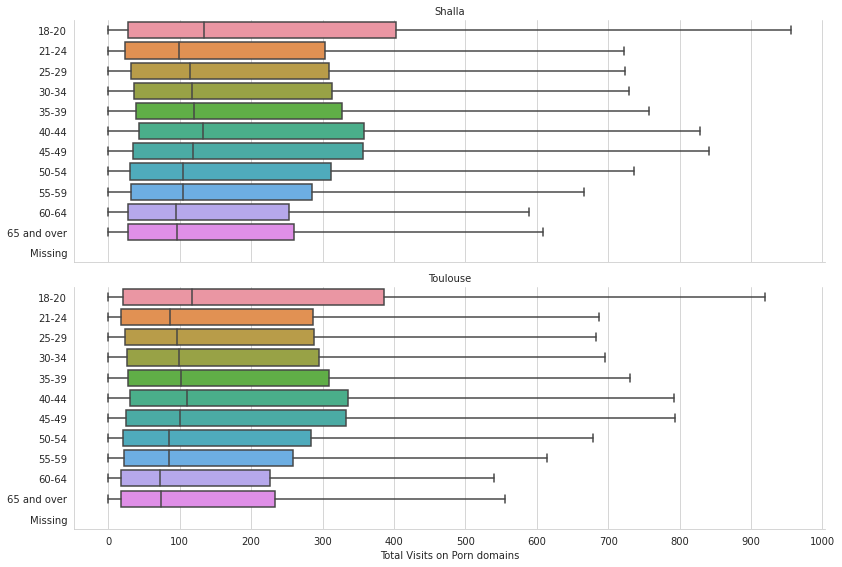

In [45]:
adf = pd.melt(df, id_vars=['hoh_oldest_age'], value_vars=grp_visits, var_name='model', value_name='total_visit')
adf['model'] = adf['model'].replace({'total_visits_porn_shalla': 'Shalla', 'total_visits_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="total_visit", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total Visits on Porn domains by Age')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(10))

g.savefig('./total_visits_porn_age.eps', format='eps', dpi=300)

### Average Time Spent on Pornographic Sites by Age

In [47]:
df.groupby(['hoh_oldest_age'])[grp_time].describe().round(1).loc[:, sel_cols].astype('int')

total_time_porn_shalla                  \
                                 mean  25%  50%   75%   
hoh_oldest_age                                          
18-20                            2828  137  717  2487   
21-24                            2085  114  524  1937   
25-29                            2265  150  615  1957   
30-34                            2367  189  667  2039   
35-39                            2747  194  692  2060   
40-44                            2678  218  753  2307   
45-49                            2602  174  664  2309   
50-54                            2668  148  582  1979   
55-59                            2422  143  587  1813   
60-64                            2050  130  537  1671   
65 and over                      2012  126  491  1635   

               total_time_porn_toulouse                  
                                   mean  25%  50%   75%  
hoh_oldest_age                                           
18-20                              2543   90  560  2151  
21-24                              1804   72  400  1521  
25-29                              1955  101  440  1600  
30-34                              2058  116  487  1600  
35-39                              2353  123  501  1605  
40-44                              2268  139  546  1774  
45-49                              2212  106  481  1811  
50-54                              2301   91  403  1561  
55-59                              2074   88  397  1410  
60-64                              1741   74  344  1224  
65 and over                        1658   71  333  1205

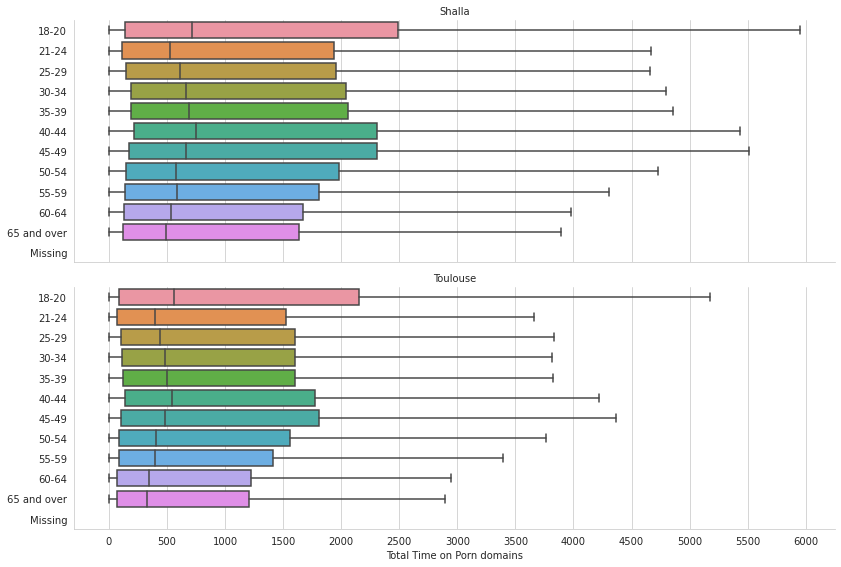

In [48]:
adf = pd.melt(df, id_vars=['hoh_oldest_age'], value_vars=grp_time, var_name='model', value_name='total_time')
adf['model'] = adf['model'].replace({'total_time_porn_shalla': 'Shalla', 'total_time_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="total_time", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total Time on Porn domains by Age')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(500))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(100))

g.savefig('./total_time_porn_age.eps', format='eps', dpi=300)

### Average Number of Visits to Pornographic Sites by Education

As education levels increase, the average number of visits go down. Households where the most educated person in the household has a graduate degree visit pornographic sites less often and spent less time on them than households where the most educated person has less than a HS diploma.

In [49]:
df.groupby(['hoh_most_education'])[grp_visits].describe().round(1).loc[:, sel_cols].astype('int').reindex(edu.values())

total_visits_porn_shalla                \
                                                      mean 25%  50%  75%   
hoh_most_education                                                         
Less than a high school diploma                        403  41  136  416   
High school diploma or equivalent                      363  34  112  312   
Some college but no degree                             374  31  110  309   
Associate degree                                       364  33  112  293   
Bachelor’s degree                                      381  30  106  295   
Graduate degree                                        335  25   91  265   
Missing                                                375  35  118  335   

                                  total_visits_porn_toulouse                
                                                        mean 25%  50%  75%  
hoh_most_education                                                          
Less than a high school diploma                          386  28  121  391  
High school diploma or equivalent                        347  23   92  288  
Some college but no degree                               358  23   90  284  
Associate degree                                         348  22   92  273  
Bachelor’s degree                                        363  20   84  265  
Graduate degree                                          318  16   72  235  
Missing                                                  360  25  101  315

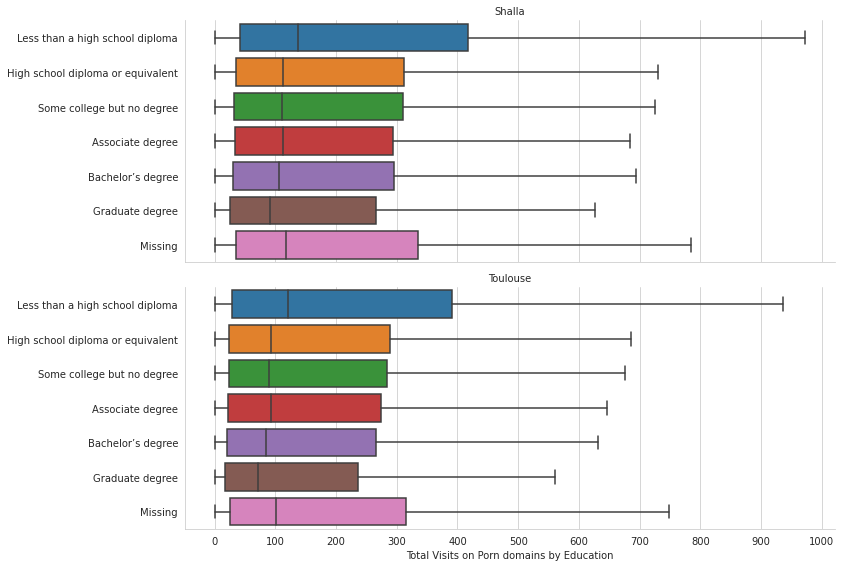

In [51]:
adf = pd.melt(df, id_vars=['hoh_most_education'], value_vars=grp_visits, var_name='model', value_name='total_visit')
adf['model'] = adf['model'].replace({'total_visits_porn_shalla': 'Shalla', 'total_visits_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="total_visit", y="hoh_most_education",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total Visits on Porn domains by Education')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(10))

g.savefig('./total_visits_porn_educ.eps', format='eps', dpi=300)

### Average Time Spent on Pornographic Sites by Education

In [52]:
df.groupby(['hoh_most_education'])[grp_time].describe().round(1).loc[:, sel_cols].astype('int').reindex(edu.values())

total_time_porn_shalla                  \
                                                    mean  25%  50%   75%   
hoh_most_education                                                         
Less than a high school diploma                     2997  212  792  2598   
High school diploma or equivalent                   2497  169  644  2058   
Some college but no degree                          2472  156  615  1927   
Associate degree                                    2317  174  629  1876   
Bachelor’s degree                                   2485  144  574  1898   
Graduate degree                                     2384  116  488  1706   
Missing                                             2464  175  661  2147   

                                  total_time_porn_toulouse                  
                                                      mean  25%  50%   75%  
hoh_most_education                                                          
Less than a high school diploma                       2568  125  577  2048  
High school diploma or equivalent                     2150  103  456  1574  
Some college but no degree                            2102   97  427  1493  
Associate degree                                      2032  101  448  1494  
Bachelor’s degree                                     2107   85  392  1439  
Graduate degree                                       1999   67  342  1356  
Missing                                               2104  109  480  1668

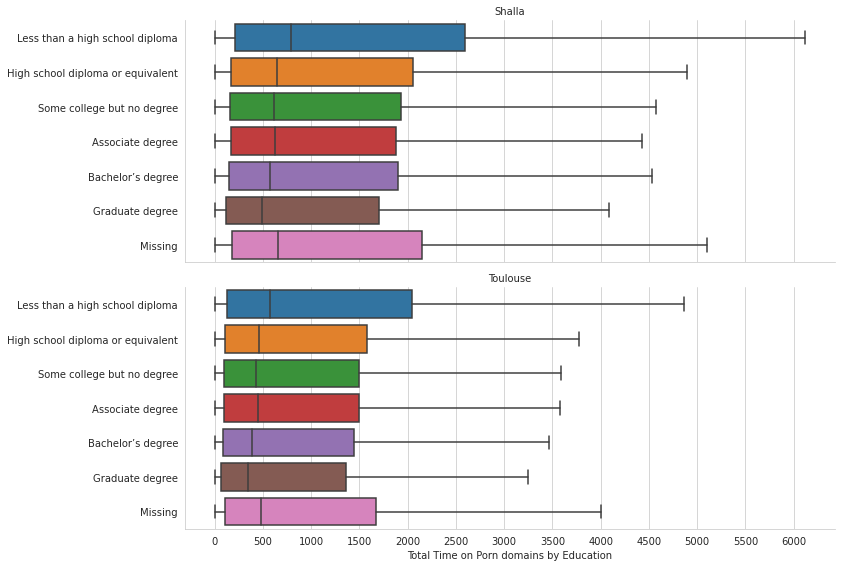

In [53]:
adf = pd.melt(df, id_vars=['hoh_most_education'], value_vars=grp_time, var_name='model', value_name='total_time')
adf['model'] = adf['model'].replace({'total_time_porn_shalla': 'Shalla', 'total_time_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="total_time", y="hoh_most_education",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total Time on Porn domains by Education')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(500))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(100))

g.savefig('./total_time_porn_educ.eps', format='eps', dpi=300)

### Proportion of Time Spent on (Proportion of Visits to) Pornographic Domains

Do we see the patterns because it just captures that certain people spend more time online? To check that we look at proportions.

The data are clear---as people get older, they generally spend a smaller proportion of time on pornographic websites with perceptible drop-offs after 50--54. Splitting by education also shows that the declining trend is a result of people in households where education level is higher spending less time on pornographic domains.

In [54]:
grp_prop_visits = []
for g in grp_visits:
    df['prop_' + g] = df[g]/df['total_visits'] 
    grp_prop_visits.append('prop_'  + g)

grp_prop_time = []
for g in grp_time:
    df['prop_' + g] = df[g]/df['total_time'] 
    grp_prop_time.append('prop_'  + g)    

#### By Age

In [55]:
df.groupby(['hoh_oldest_age'])[grp_prop_visits].mean().round(3)

,prop_total_visits_porn_shalla,prop_total_visits_porn_toulouse
hoh_oldest_age,,
18-20,0.121,0.114
21-24,0.116,0.109
25-29,0.115,0.107
30-34,0.110,0.102
35-39,0.108,0.100
40-44,0.109,0.101
45-49,0.109,0.101
50-54,0.106,0.098
55-59,0.100,0.091


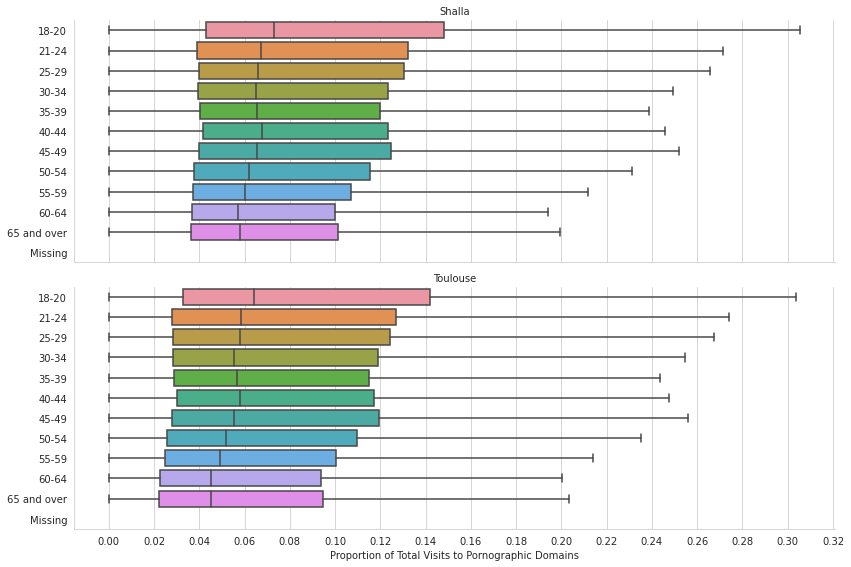

In [73]:
adf = pd.melt(df, id_vars=['hoh_oldest_age'], value_vars=grp_prop_visits, var_name='model', value_name='prop_total_visits_porn_prob')
adf['model'] = adf['model'].replace({'prop_total_visits_porn_shalla': 'Shalla', 'prop_total_visits_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="prop_total_visits_porn_prob", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Proportion of Total Visits to Pornographic Domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.02))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.005))

g.savefig('./prop_total_visits_porn_age.eps', format='eps', dpi=300)

In [74]:
df.groupby(['hoh_oldest_age'])[grp_prop_time].mean().round(3)

,prop_total_time_porn_shalla,prop_total_time_porn_toulouse
hoh_oldest_age,,
18-20,0.077,0.067
21-24,0.077,0.068
25-29,0.078,0.068
30-34,0.075,0.065
35-39,0.073,0.062
40-44,0.074,0.063
45-49,0.075,0.064
50-54,0.074,0.063
55-59,0.070,0.059


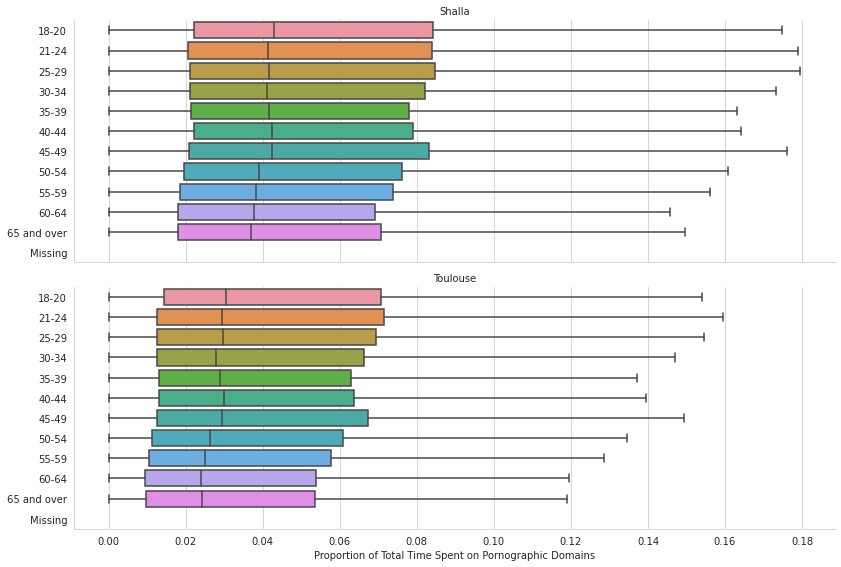

In [75]:
adf = pd.melt(df, id_vars=['hoh_oldest_age'], value_vars=grp_prop_time, var_name='model', value_name='prop_total_time_porn_prob')
adf['model'] = adf['model'].replace({'prop_total_time_porn_shalla': 'Shalla', 'prop_total_time_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="prop_total_time_porn_prob", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_ylabels('');
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_xlabels('Proportion of Total Time Spent on Pornographic Domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.02))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.005))

g.savefig('./prop_total_time_porn_age.eps', format='eps', dpi=300)

#### By Education

In [59]:
df.groupby(['hoh_most_education'])[grp_prop_visits].mean().round(3).reindex(edu.values())

,prop_total_visits_porn_shalla,prop_total_visits_porn_toulouse
hoh_most_education,,
Less than a high school diploma,0.117,0.109
High school diploma or equivalent,0.106,0.098
Some college but no degree,0.105,0.097
Associate degree,0.105,0.096
Bachelor’s degree,0.102,0.093
Graduate degree,0.096,0.087
Missing,0.109,0.101


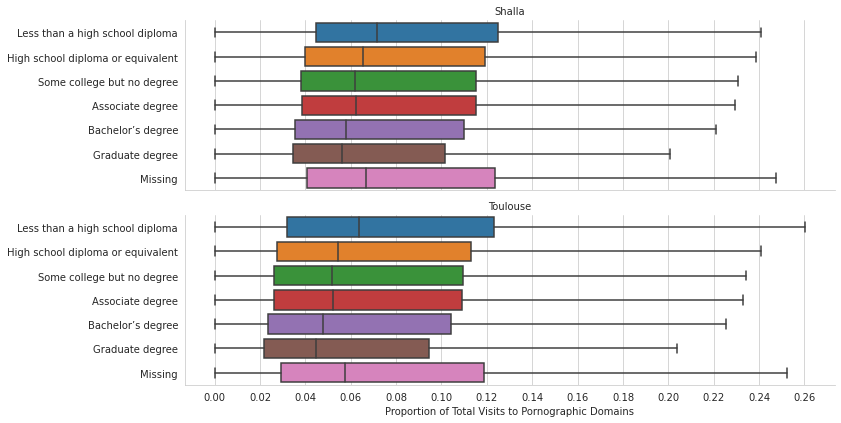

In [76]:
adf = pd.melt(df, id_vars=['hoh_most_education'], value_vars=grp_prop_visits, var_name='model', value_name='prop_total_visits_porn_prob')
adf['model'] = adf['model'].replace({'prop_total_visits_porn_shalla': 'Shalla', 'prop_total_visits_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="prop_total_visits_porn_prob", y="hoh_most_education",
                col='model', col_wrap=1, height=3, aspect=4,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_ylabels('');
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_xlabels('Proportion of Total Visits to Pornographic Domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.02))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.005))

g.savefig('./prop_total_visits_porn_edu.eps', format='eps', dpi=300)

In [61]:
df.groupby(['hoh_most_education'])[grp_prop_time].mean().round(3).reindex(edu.values())

,prop_total_time_porn_shalla,prop_total_time_porn_toulouse
hoh_most_education,,
Less than a high school diploma,0.079,0.067
High school diploma or equivalent,0.074,0.063
Some college but no degree,0.071,0.060
Associate degree,0.072,0.061
Bachelor’s degree,0.072,0.061
Graduate degree,0.069,0.059
Missing,0.074,0.063


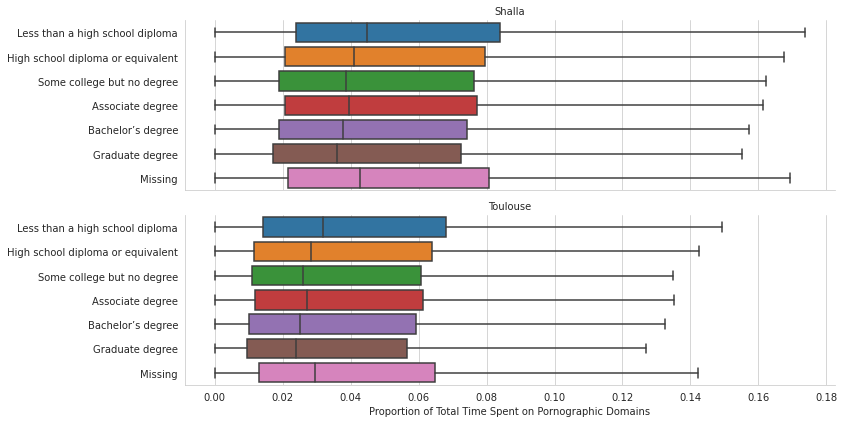

In [77]:
adf = pd.melt(df, id_vars=['hoh_most_education'], value_vars=grp_prop_time, var_name='model', value_name='prop_total_time_porn_prob')
adf['model'] = adf['model'].replace({'prop_total_time_porn_shalla': 'Shalla', 'prop_total_time_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="prop_total_time_porn_prob", y="hoh_most_education",
                col='model', col_wrap=1, height=3, aspect=4,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_ylabels('');
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_xlabels('Proportion of Total Time Spent on Pornographic Domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.02))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.005))

g.savefig('./prop_total_time_porn_educ.eps', format='eps', dpi=300)    